## Objective

(Gene, Variation, Text)[INPUT] ---- > [ML model] ----> [OUTPUT](Cancer type label)



* No low-latency requirement.
* Interpretability is important. (To know reaon of cancer)
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.
* There are nine different classes a genetic mutation  => Multi class classification problem
* Since output are based on probabilities -- > Log Loss and Confusion Matrix 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings   # to ignore the various warning poping up while block execution
warnings.filterwarnings('ignore')

## Reading Data from CSV files

In [2]:
# Reading  data from the csv files
df_variants = pd.read_csv('training_variants')
print(df_variants.head())
df_variants.info()

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [3]:
df_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print(df_text.head())
df_text.info()

   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


## Dataframe Preprocessing and cleaning

In [4]:
from nltk.corpus import stopwords
import re # for regular expression
import time # to see the execution time of cell, start_time = time.clock(), end_time = time.clock()

In [5]:
stop_words = set(stopwords.words("english"))

def text_preprocessing(text):
    """Function to clean the text by using regular exp and removing stopwords"""
    if type(text) == type('a'):
        text = re.sub(re.compile(r'[^a-zA-Z0-9\n]'), " ", text)  # replacing the special character
        text = re.sub(re.compile(r'\s+'), " ", text)
        text = text.lower()
        
        clean_text = ""
        for word in text.split():
            if word not in stop_words:
                clean_text = clean_text + word + " "         
        return clean_text

In [6]:
start_time = time.clock()

df_text.TEXT = df_text.TEXT.apply(text_preprocessing)

end_time = time.clock()
print("Time taken to run the block = ",end_time-start_time," secs")

Time taken to run the block =  166.7357358  secs


In [7]:
df_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
# preprcoessing for df_variants

df_variants.Gene = df_variants.Gene.str.replace('\s+','_')
df_variants.Variation = df_variants.Variation.str.replace('\s+','_')

In [9]:
# Merging both  dataframes

df = pd.merge(df_variants,df_text,on='ID',how='left')
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
# checking and filling null values of text

df[df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,None
1277,1277,ARID5B,Truncating_Mutations,1,None
1407,1407,FGFR3,K508M,6,None
1639,1639,FLT1,Amplification,6,None
2755,2755,BRAF,G596C,7,None


In [11]:
# filling the null values with the 'gene + Variation text'
df.loc[df['TEXT'].isnull(),'TEXT'] = df['Gene'] +' '+df['Variation']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3321 non-null object
dtypes: int64(2), object(3)
memory usage: 315.7+ KB


## Splitting the Dataset into Train, CV and Test

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# giving "stratify = df['Class']" will maintain the random distribution of dataset a/c to df['Class']  

x_df , x_test, y_df ,y_test = train_test_split(df, df['Class'], stratify = df['Class'].values, test_size=0.20)

# again breaking for train and CV
x_train, x_cv, y_train, y_cv = train_test_split(x_df, y_df, stratify = y_df, test_size=0.20)

In [123]:
x_train.Class.value_counts()

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

In [124]:
x_test.Class.value_counts()

7    191
4    137
1    114
2     91
6     55
5     48
3     18
9      7
8      4
Name: Class, dtype: int64

In [125]:
x_cv.Class.value_counts()

7    153
4    110
1     91
2     72
6     44
5     39
3     14
9      6
8      3
Name: Class, dtype: int64

In [18]:
# Above distributions also shows that the dataset in Imbalanceed

## Function for plotting Confusion matrix

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [283]:
def plot_confusion_matrix(y_test, y_predicted):
   
    c_labels = [1,2,3,4,5,6,7,8,9]
    
        
    # Confusion Matrix and its presentation
    confusion = confusion_matrix(y_test, y_predicted)
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(confusion, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Precision Matrix
    precision = confusion/confusion.sum(axis=0)

    print("-"*20, "Presion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(precision, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels = c_labels, yticklabels= c_labels)
    plt.xlabel("Predcited Class")
    plt.ylabel("Original Class")
    plt.show()
    
    
    # Recall Matrix
    recall = ((confusion.T)/((confusion.T).sum(axis=0))).T
    
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(recall, annot=True, cmap="YlGnBu", fmt=".3f",xticklabels = c_labels, yticklabels= c_labels )
    plt.xlabel("Predcited Class")
    plt.ylabel("Original Class")
    plt.show()
    

## Predicting using Random Model

## Categorical Feature -- > Numerical Feature

In [111]:
print("No of unique genes - ",df.Gene.value_counts().shape[0])
print("\nTop 10 genes - ")
df.Gene.value_counts().head(10)

No of unique genes -  264

Top 10 genes - 


BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

In [112]:
# # 264 type of genes
# Methods available for encoding --
# 1. one hot encoding  - for (Logistic regression , linear svm)
# 2. Response coding  - for (random foredt, Naive Bayes)

In [113]:
#  when we caculate the probability of a feature belongs to any particular class,also by apply laplace smoothing
#  prob = (numerator + 10\*alpha) / (denominator + 90\*alpha)

def prob_count(dataframe, feature, alpha):
    feature_dict = dict()
    for gene_type, no_of_gene in dataframe[feature].value_counts().items():
        prob_vec = []
        for i in range(1,10):
            no_class_type = dataframe[(dataframe[feature]==gene_type) & (dataframe.Class==i)].shape[0]
            prob = (int(no_class_type) + alpha*10)/(int(no_of_gene) + 90*alpha)
            prob_vec.append(prob)
        feature_dict[gene_type]= prob_vec
    return feature_dict

In [114]:
def feature_apply(dataframe, feature, alpha):
    
    dic = prob_count(dataframe,feature, alpha)
    
    value_count = dataframe[feature].value_counts()
    gv_fea = []
   
    for index, row in dataframe.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(dic[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

#### Difference between the Onehot and Resemble encoding dimensionality 

* Response Coding shape -- (2124 , 9 )
* One hot encoding shape -- (2124 , 230 )

# Univariant Analysis on feature -- "Gene"

* To check the imporatance of "Gene" feature in predicting the model
* Train a simple model by taking "Gene" as only feature
* Compare the Logg loss of above model with Random Model
* If log loss Simple model < log loss Random model, then "Gene" can be considered useful feature

In [128]:
# Coverting the features of dataset onto Response Coding --

train_response_coded = np.array(feature_apply(x_train, "Gene", 1))
test_response_coded = np.array(feature_apply(x_test, "Gene", 1))
cv_response_coded = np.array(feature_apply(x_cv, "Gene", 1))

In [131]:
train_response_coded.shape , test_response_coded.shape , cv_response_coded.shape

((2124, 9), (665, 9), (532, 9))

In [174]:
# One hot encoding of the "Gene"

from sklearn.feature_extraction.text import CountVectorizer

gene_vectorizer = CountVectorizer()
train_gene_onehot = gene_vectorizer.fit_transform(x_train.Gene)
test_gene_onehot = gene_vectorizer.transform(x_test.Gene)
cv_gene_onehot = gene_vectorizer.transform(x_cv.Gene)

In [175]:
train_gene_onehot.shape,  test_gene_onehot.shape, cv_gene_onehot.shape

((2124, 230), (665, 230), (532, 230))

In [101]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV # probalistic predicted model needed to be calibrated
from sklearn.metrics.classification import accuracy_score, log_loss

In [186]:
# implementing LOGISTIC REGRESSION in SGDClassifier --
# First with Response Encoding

alpha = [10**x for x in range(-5,2)]

log_loss_array = []

for i in alpha:
    model = SGDClassifier(loss='log',penalty='l2',alpha=i, random_state=42)
    model.fit(train_response_coded ,y_train)
    sigmoid_model = CalibratedClassifierCV( model , method='sigmoid')
    sigmoid_model.fit(train_response_coded,y_train)
    predict_y = sigmoid_model.predict_proba(cv_response_coded)
    log_loss_array.append(log_loss(y_cv, predict_y))
    print("Log loss for aplha = ",i," is ",log_loss(y_cv, predict_y, labels=model.classes_))

Log loss for aplha =  1e-05  is  1.3917533656368415
Log loss for aplha =  0.0001  is  1.4083940869639775
Log loss for aplha =  0.001  is  1.4703591539071679
Log loss for aplha =  0.01  is  1.502269165547802
Log loss for aplha =  0.1  is  1.5080843250146783
Log loss for aplha =  1  is  1.5047469553775108
Log loss for aplha =  10  is  1.477187220895148


In [187]:
# trainning model with best alpha = 10**-5
alpha=1e-05
model = SGDClassifier(loss='log',penalty='l2',alpha=1e-05,random_state=42)
model.fit(train_response_coded, y_train)
sigmoid_model = CalibratedClassifierCV(model,method='sigmoid')
sigmoid_model.fit(train_response_coded, y_train)


predict_y  = sigmoid_model.predict_proba(train_response_coded)
print('For values of best alpha = ', alpha, " The train log loss is:",log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y  = sigmoid_model.predict_proba(cv_response_coded)
print('For values of best alpha = ', alpha, " The cross validation log loss is:",log_loss(y_cv, predict_y, labels=model.classes_, eps=1e-15))
predict_y  = sigmoid_model.predict_proba(test_response_coded)
print('For values of best alpha = ', alpha, " The test log loss is:",log_loss(y_test, predict_y, labels=model.classes_, eps=1e-15))


For values of best alpha =  1e-05  The train log loss is: 1.171074312545567
For values of best alpha =  1e-05  The cross validation log loss is: 1.3917533656368415
For values of best alpha =  1e-05  The test log loss is: 1.3713953775684529


In [188]:
# there is not much difference between the train an test log loss and much less then Random model logg loss, this shows ---
#  1) "Gene" feature is useful
#  2) Model is not overfit,
# Now Trying to reduce the loss furthus reducing the overfitting

In [189]:
# Implementing Linear regg with Onehot Encoding
alpha = [10**x for x in range(-5,2)]
log_loss_array = []

for i in alpha:
    model = SGDClassifier(loss="log",penalty='l2',alpha=i,random_state=42)
    model.fit(train_gene_onehot, y_train)
    sigmoid_model = CalibratedClassifierCV(model, method='sigmoid')
    sigmoid_model.fit(train_gene_onehot, y_train)
    predict_y = sigmoid_model.predict_proba(cv_gene_onehot)
    log_loss_array.append(log_loss(y_cv, predict_y, labels=model.classes_))
    print("Log loss for aplha = ",i," is ",log_loss(y_cv, predict_y, labels=model.classes_))

Log loss for aplha =  1e-05  is  1.3971465399382268
Log loss for aplha =  0.0001  is  1.235717148338864
Log loss for aplha =  0.001  is  1.2700875730695023
Log loss for aplha =  0.01  is  1.3780895104375896
Log loss for aplha =  0.1  is  1.4545261923537602
Log loss for aplha =  1  is  1.4792869379682054
Log loss for aplha =  10  is  1.4828140475194644


## Univariant Analysis on feature -- "Variation"

In [160]:
print("Number of unique variations = ",x_train.Variation.value_counts().shape[0])
x_train.Variation.value_counts().head()

Number of unique variations =  1935


Truncating_Mutations    63
Deletion                45
Amplification           44
Fusions                 23
Overexpression           3
Name: Variation, dtype: int64

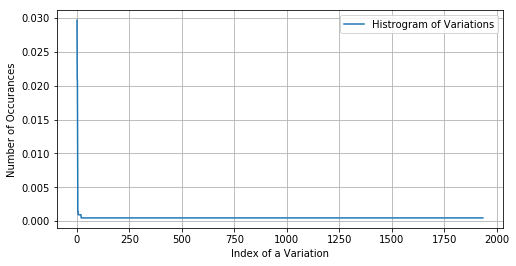

In [162]:
# Plotting HISTOGRAM to see the distribution of variations

plt.figure(figsize=(8,4))
s = sum(x_train.Variation.value_counts().values);
h = x_train.Variation.value_counts().values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

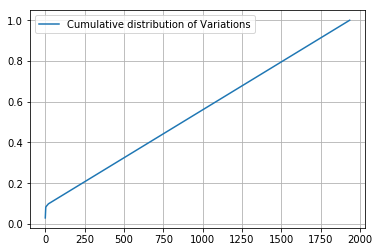

In [200]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()


'''curve is almost staright linear line, this sows if we select lets top 1500 feature
   a/c to the y-axis prob reading = 80%, i.e. top 1500 features out of 1925 only contributes 80%
   this shows most variation occur once'''

In [164]:
# Methods available to featurize :
# 1) One hot Encoding
# 2) Response coding

In [166]:
# Response Coding
alpha = 1 # taken for laplace smoothing

train_var_res  = np.array(feature_apply(x_train,'Variation',1 ))
test_var_res = np.array(feature_apply(x_test,'Variation',1))
cv_var_res = np.array(feature_apply(x_cv,'Variation',1))

In [168]:
train_var_res.shape, test_var_res.shape, cv_var_res.shape

((2124, 9), (665, 9), (532, 9))

In [169]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

In [173]:
train_variation_feature_onehotCoding.shape , test_variation_feature_onehotCoding.shape,  cv_variation_feature_onehotCoding.shape

((2124, 1962), (665, 1962), (532, 1962))

In [191]:
len(variation_vectorizer.get_feature_names())

1962

In [195]:
# trainning model on logistic regg using one hot encoded data

alpha = [10**x for x in range(-5,2)]
log_loss_array = []

for i in alpha:
    model = SGDClassifier(loss='log', penalty='l2',alpha=i, random_state=42)
    model.fit(train_variation_feature_onehotCoding, y_train)
    sigmoid_model = CalibratedClassifierCV(model, method='sigmoid')
    sigmoid_model.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sigmoid_model.predict_proba(cv_variation_feature_onehotCoding)
    log_loss_array.append(log_loss(y_cv, predict_y))
    print("Log loss for aplha = ",i," is ",log_loss(y_cv, predict_y, labels=model.classes_))

Log loss for aplha =  1e-05  is  1.7349383791868123
Log loss for aplha =  0.0001  is  1.7221588589493528
Log loss for aplha =  0.001  is  1.7216159120667356
Log loss for aplha =  0.01  is  1.727535368297859
Log loss for aplha =  0.1  is  1.7350697615182857
Log loss for aplha =  1  is  1.7364241940001783
Log loss for aplha =  10  is  1.736589177903987


In [199]:
# trainning model at best alpha = 0.001
alpha = 0.001

model = SGDClassifier(loss='log',penalty='l2',alpha=0.001,random_state=42)
model.fit(train_variation_feature_onehotCoding, y_train)
sigmoid_model = CalibratedClassifierCV(model,method='sigmoid')
sigmoid_model.fit(train_variation_feature_onehotCoding, y_train)


predict_y  = sigmoid_model.predict_proba(train_variation_feature_onehotCoding)

print('For values of best alpha = ', alpha, " The train log loss is:",log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y  = sigmoid_model.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha, " The cross validation log loss is:",log_loss(y_cv, predict_y, labels=model.classes_, eps=1e-15))
predict_y  = sigmoid_model.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha, " The test log loss is:",log_loss(y_test, predict_y, labels=model.classes_, eps=1e-15))


For values of best alpha =  0.001  The train log loss is: 1.1163090624636873
For values of best alpha =  0.001  The cross validation log loss is: 1.7216159120667356
For values of best alpha =  0.001  The test log loss is: 1.7150314078187232


In [203]:
# 
# Conlusions from 'Variation' analysis-
# 1) Variation feature is useful as loss less then random model
# 2) More instability in variation then gene feature as in variation train, cv and test loss have marginal difference
# 3) Gene more stable as compared to variation
# 

## Univariant Analysis on feature -- "Text"

In [205]:
x_train.TEXT.head()

2881    abstract classification rare missense variants...
1295    three dimensional structure complex human h ra...
1491    abstract prospective clinical sequencing progr...
2905    neurofibromatosis type 2 nf2 multiple neoplasi...
343     41 year old man familial history gastric cance...
Name: TEXT, dtype: object

In [242]:
# functiion to count the no of words in each row
from collections import defaultdict

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [243]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [237]:
# Text feature one hot incoding- 

from sklearn.feature_extraction.text import CountVectorizer
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train.TEXT)

train_text_features = text_vectorizer.get_feature_names()
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53994


In [235]:
train_text_onehot_encode.shape

(2124, 53994)

In [244]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(x_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [246]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

In [247]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [250]:
from sklearn.preprocessing import normalize
# Normalizing every vector

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [251]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [253]:
alpha = [10**x for x in range(-5,2)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3650447261379834
For values of alpha =  0.0001 The log loss is: 1.3170905152904284
For values of alpha =  0.001 The log loss is: 1.1756495758154049
For values of alpha =  0.01 The log loss is: 1.258298277466114
For values of alpha =  0.1 The log loss is: 1.4648553813858824
For values of alpha =  1 The log loss is: 1.6712464013672659
For values of alpha =  10 The log loss is: 1.7044766449267803


In [257]:
# The best alpha = 0.001
alpha = 0.001

# trainning model on best alpha

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7849638132676389
For values of best alpha =  0.001 The cross validation log loss is: 1.1756495758154049
For values of best alpha =  0.001 The test log loss is: 1.1425619381385108


Following to be asked from all features - 
1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

## Merging the data

In [258]:
from scipy.sparse import hstack, vstack

In [265]:
# One hot Encoding Data

train_gene_var_onehot = hstack((train_gene_onehot,train_variation_feature_onehotCoding))
test_gene_var_onehot = hstack((test_gene_onehot,test_variation_feature_onehotCoding))
cv_gene_var_onehot = hstack((cv_gene_onehot,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehot, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehot, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehot, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))

print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56186)
(number of data points * number of features) in test data =  (665, 56186)
(number of data points * number of features) in cross validation data = (532, 56186)


In [297]:
# Response Coding Data

train_gene_var_responseCoding = np.hstack((train_gene_response,train_var_res))
test_gene_var_responseCoding = np.hstack((test_gene_response,test_var_res))
cv_gene_var_responseCoding = np.hstack((cv_gene_response,cv_var_res))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


## Naive Bays (Baseline Model)

In [271]:
from sklearn.naive_bayes import MultinomialNB # haning multiple classes

In [275]:
alpha = [10**x for x in range(-5,2)]
cv_logloss_array = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)," For alpha = ",i) 
    

Log Loss : 1.29794252840723  For alpha =  1e-05
Log Loss : 1.295867489977237  For alpha =  0.0001
Log Loss : 1.2999103131535357  For alpha =  0.001
Log Loss : 1.301798781033563  For alpha =  0.01
Log Loss : 1.3196815855225286  For alpha =  0.1
Log Loss : 1.3456016304356082  For alpha =  1
Log Loss : 1.3964065509815382  For alpha =  10


In [280]:
# best alpha = 0.0001
best_alpha = 0.0001
clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', best_alpha, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.8806747652737554
For values of best alpha =  0.0001 The cross validation log loss is: 1.295867489977237
For values of best alpha =  0.0001 The test log loss is: 1.2724920025131252


In [292]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train['Gene'])
    var_vec  = var_count_vec.fit(x_train['Variation'])
    text_vec = text_count_vec.fit(x_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [293]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_train['TEXT'].iloc[test_point_index],x_train['Gene'].iloc[test_point_index],x_train['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1103 0.5172 0.0131 0.1286 0.0494 0.0421 0.1313 0.0055 0.0025]]
Actual Class : 2
--------------------------------------------------
17 Text feature [novel] present in test data point [True]
18 Text feature [identified] present in test data point [True]
19 Text feature [molecular] present in test data point [True]
23 Text feature [including] present in test data point [True]
24 Text feature [time] present in test data point [True]
25 Text feature [new] present in test data point [True]
26 Text feature [confirmed] present in test data point [True]
27 Text feature [another] present in test data point [True]
28 Text feature [different] present in test data point [True]
29 Text feature [found] present in test data point [True]
30 Text feature [recently] present in test data point [True]
31 Text feature [well] present in test data point [True]
32 Text feature [identification] present in test data point [True]
34 Text feature [potential] p

## KNN

In [301]:
from sklearn.neighbors import KNeighborsClassifier

In [298]:
# KNN dont work best with large dimensionality
# hence instead of Onehot encoding - PESPONSE coding used with 9 features

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 5
Log Loss : 0.9767519132080404
for alpha = 11
Log Loss : 1.0141874695062616
for alpha = 15
Log Loss : 1.02672583597814
for alpha = 21
Log Loss : 1.0405414165225093
for alpha = 31
Log Loss : 1.065371124892595
for alpha = 41
Log Loss : 1.074852103802159
for alpha = 51
Log Loss : 1.086165338442726
for alpha = 99
Log Loss : 1.1616878969128774
For values of best alpha =  5 The train log loss is: 0.4705959631023044
For values of best alpha =  5 The cross validation log loss is: 0.9767519132080404
For values of best alpha =  5 The test log loss is: 0.9266963206170508


## Logistic Regression (With Class Balancing)

In [323]:
# Model complexity increases downword ->

# Naive Bays (can deal with large dimesionality) 
# KNN (can't deal with large dimesionality)
# Logisctic Regg(can deal with large dimesionality) 

In [326]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs),"for alpha =", i) 

Log Loss : 1.3841504995321026 for alpha = 1e-06
Log Loss : 1.3739018751137557 for alpha = 1e-05
Log Loss : 1.3084758548947837 for alpha = 0.0001
Log Loss : 1.085104533444946 for alpha = 0.001
Log Loss : 1.1412693442313302 for alpha = 0.01
Log Loss : 1.512961011189445 for alpha = 0.1
Log Loss : 1.7310198582185214 for alpha = 1
Log Loss : 1.7519279274949409 for alpha = 10
Log Loss : 1.7540776024928375 for alpha = 100


In [327]:
# Trainning model with best alpha = 0.001 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6430440608605126
For values of best alpha =  0.001 The cross validation log loss is: 1.085104533444946
For values of best alpha =  0.001 The test log loss is: 1.0647439432231667


## Logistic Regression (Without Class Balancing)

In [330]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs),"for alpha =", i) 

Log Loss : 1.348756545123912 for alpha = 1e-06
Log Loss : 1.3383874533988211 for alpha = 1e-05
Log Loss : 1.2944675298354409 for alpha = 0.0001
Log Loss : 1.1189397576709106 for alpha = 0.001
Log Loss : 1.2022337139591928 for alpha = 0.01
Log Loss : 1.3830852093239379 for alpha = 0.1
Log Loss : 1.6150790873769503 for alpha = 1
Log Loss : 1.656181194272004 for alpha = 10
Log Loss : 1.6606932992385937 for alpha = 100


In [331]:
# Trainning model with best alpha = 0.001 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6321985273917882
For values of best alpha =  0.001 The cross validation log loss is: 1.1189397576709106
For values of best alpha =  0.001 The test log loss is: 1.0811683048362903


## Linear SVM (with ClassBalanced)

* RBK and Kernal SVM not used as we dont know the right kernal
* in case we used text or RBF kernal the trained model is not interpretable
* In linear SVM its easy to get feature imporatance, they are just like the logistic regg.


In [332]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs),"for alpha =", i) 

Log Loss : 1.3575829531084793 for alpha = 1e-06
Log Loss : 1.3667828818906311 for alpha = 1e-05
Log Loss : 1.316344250040108 for alpha = 0.0001
Log Loss : 1.2242403052757578 for alpha = 0.001
Log Loss : 1.172015362458566 for alpha = 0.01
Log Loss : 1.3986220765454684 for alpha = 0.1
Log Loss : 1.7449821872000097 for alpha = 1
Log Loss : 1.754425392450009 for alpha = 10
Log Loss : 1.7544253965147187 for alpha = 100


In [333]:
# Trainning model with best alpha = 0.001 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.7763267349063716
For values of best alpha =  0.01 The cross validation log loss is: 1.172015362458566
For values of best alpha =  0.01 The test log loss is: 1.1348984683888912


In [336]:
sig_clf.get_params

<bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')>

## Random Forest Classifier (With Onehot Encoding)

In [337]:
from sklearn.ensemble import RandomForestClassifier

In [339]:
base_learners = [100,200,500,1000,2000]
tree_depth = [5,10]
cv_log_error_array = []
for base in base_learners:
    for depth in tree_depth:
            clf = RandomForestClassifier(n_estimators=base, criterion='gini', max_depth=depth, n_jobs=-1, random_state=42)
            clf.fit(train_x_onehotCoding , y_train)
            sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
            sig_clf.fit(train_x_onehotCoding, y_train)
            sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
            cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

Logg loss =  1.2473383364263193  at Max_depth =  5  and No of base_learners =  100
Logg loss =  1.1938531924106026  at Max_depth =  10  and No of base_learners =  100
Logg loss =  1.245205848434237  at Max_depth =  5  and No of base_learners =  200
Logg loss =  1.1903654274216724  at Max_depth =  10  and No of base_learners =  200
Logg loss =  1.2442697963584366  at Max_depth =  5  and No of base_learners =  500
Logg loss =  1.1814622975251694  at Max_depth =  10  and No of base_learners =  500
Logg loss =  1.2379356765803096  at Max_depth =  5  and No of base_learners =  1000
Logg loss =  1.1761730356562223  at Max_depth =  10  and No of base_learners =  1000
Logg loss =  1.2397806154277424  at Max_depth =  5  and No of base_learners =  2000
Logg loss =  1.1733295762886249  at Max_depth =  10  and No of base_learners =  2000


In [340]:
# trainning model with best hyperparameter
# base_learners = 2000   , tree_depth = 10
base_learners = 2000
tree_depth = 10
clf = RandomForestClassifier(n_estimators=2000 , criterion='gini', max_depth=10 , random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', base_learners, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', base_learners, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', base_learners, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.7236570293240685
For values of best estimator =  2000 The cross validation log loss is: 1.1733295762886249
For values of best estimator =  2000 The test log loss is: 1.1885092967243407


## Stacking Ensamble

In [343]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [344]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))


clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.75
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.046
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.557
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.165
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.236
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.480


In [346]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

Log loss (train) on the stacking classifier : 0.6925169651269207
Log loss (CV) on the stacking classifier : 1.1647871909974135
Log loss (test) on the stacking classifier : 1.122875556056284
